In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras as tfk

from sklearn.preprocessing import StandardScaler
from keras.callbacks import Callback

from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, LayerNormalization

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
plt.style.use('seaborn')
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

from utils import preprocess_time_series_v2

Using TensorFlow backend.


In [2]:
df = pd.read_csv('REE_2016_2020_gluonTS.csv')


In [3]:
df = pd.read_csv('REE_2016_2020_gluonTS.csv')

X_train, y_train, X_val, y_val, X_test, y_test, scaler = preprocess_time_series_v2(df, date_init='2016', date_final='2017', date_val='2018', date_test='2019', 
                            past_timestamps=96, forecasting_horizon=6, 
                            standarize=True, metafeatures=False, tendency=False)

                      Date  value
0      2016-01-02 23:00:00  24151
1      2016-01-03 00:00:00  22170
2      2016-01-03 01:00:00  20691
3      2016-01-03 02:00:00  19737
4      2016-01-03 03:00:00  19437
...                    ...    ...
34940  2019-12-28 19:00:00  29282
34941  2019-12-28 20:00:00  29266
34942  2019-12-28 21:00:00  28022
34943  2019-12-28 22:00:00  25964
34944  2019-12-28 23:00:00  24680

[34945 rows x 2 columns]
(17497, 1)
(8760, 1)
(8688, 1)
shape train/val (17497, 1) (8760, 1) (8688, 1)
Tamano de la serie temporal 2
Tamano de la serie temporal 2
Tamano de la serie temporal 2
shape train/val (17396, 96, 1, 1) (8659, 96, 1, 1) (8587, 96, 1, 1)
(17396, 96, 1, 1)
/home/blasting/TFG_TimeSeries/notebooks/utils.py:131: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  val_data = df[date_val].to_numpy()
/home/bl

In [4]:
X_val.shape

(8659, 96, 1)

In [5]:
y_val.shape

(8659, 6)

In [6]:

n_neurons_per_layer = int(2/3*(X_train.shape[1]*X_train.shape[2]))

inputs = tfk.layers.Input(shape=(X_train.shape[1], X_train.shape[2]))
rnn_output = tfk.layers.SimpleRNN(n_neurons_per_layer, return_sequences=True)(inputs)
rnn_output = tfk.layers.SimpleRNN(n_neurons_per_layer)(rnn_output)

outputs = tfk.layers.Dense(y_train.shape[1], activation='linear')(rnn_output)

model = tfk.Model(inputs=inputs, outputs=outputs)
model.compile(loss=tfk.losses.MeanSquaredError(), optimizer= tfk.optimizers.Adam(),
metrics=[tfk.metrics.MeanAbsoluteError()])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 1)]           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 96, 64)            4224      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
Total params: 12,870
Trainable params: 12,870
Non-trainable params: 0
_________________________________________________________________


In [7]:
batch_size = 256
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=50, 
                    validation_data=(X_val, y_val)) 


loss = history.history['loss']            #entrenamiento
val_loss = history.history['val_loss']    #validacion
#val_mse = history.history['val_mse']    #validacion
#mse = history.history['mse']    #validacion


Epoch 1/50
68/68 [==============================] - 12s 157ms/step - loss: 0.4994 - mean_absolute_error: 0.5247 - val_loss: 0.1008 - val_mean_absolute_error: 0.2247
Epoch 2/50
68/68 [==============================] - 7s 109ms/step - loss: 0.0916 - mean_absolute_error: 0.2145 - val_loss: 0.0680 - val_mean_absolute_error: 0.1819
Epoch 3/50
68/68 [==============================] - 7s 104ms/step - loss: 0.0639 - mean_absolute_error: 0.1776 - val_loss: 0.0553 - val_mean_absolute_error: 0.1687
Epoch 4/50
68/68 [==============================] - 7s 104ms/step - loss: 0.0520 - mean_absolute_error: 0.1629 - val_loss: 0.0458 - val_mean_absolute_error: 0.1525
Epoch 5/50
68/68 [==============================] - 7s 104ms/step - loss: 0.0428 - mean_absolute_error: 0.1464 - val_loss: 0.0375 - val_mean_absolute_error: 0.1374
Epoch 6/50
68/68 [==============================] - 7s 103ms/step - loss: 0.0365 - mean_absolute_error: 0.1361 - val_loss: 0.0364 - val_mean_absolute_error: 0.1313
Epoch 7/50
68/6

In [8]:
def inverse_transform(yhat, y, scaler):
	return scaler.inverse_transform(y),  scaler.inverse_transform(yhat)


In [9]:
y_hat = model.predict(X_test)
y_hat_2 = model.predict(X_val)

y_test, y_hat = inverse_transform(y_hat, y_test, scaler)
y_val, y_hat_2 = inverse_transform(y_hat_2, y_val, scaler)

In [10]:
y_hat

array([[26732.398, 24916.008, 23605.754, 23446.664, 23479.973, 24711.87 ],
       [24998.113, 23860.781, 22973.598, 23094.178, 24384.715, 26369.53 ],
       [23958.21 , 23210.844, 23305.922, 23846.844, 26173.63 , 28716.875],
       ...,
       [25698.951, 27716.76 , 28867.623, 29295.387, 29281.754, 27380.908],
       [27447.37 , 28461.936, 28787.297, 28562.398, 27264.916, 24756.959],
       [29264.441, 29395.807, 28995.248, 27490.738, 25280.33 , 23735.463]],
      dtype=float32)

In [11]:
y_val

array([[24999., 23645., 23050., 22811., 23057., 24601.],
       [23645., 23050., 22811., 23057., 24601., 27715.],
       [23050., 22811., 23057., 24601., 27715., 29787.],
       ...,
       [26628., 29371., 30659., 29852., 28274., 25926.],
       [29371., 30659., 29852., 28274., 25926., 24589.],
       [30659., 29852., 28274., 25926., 24589., 23459.]])

In [12]:
from sklearn.metrics import mean_absolute_error
def evaluate_forecasts(test, forecasts, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = mean_absolute_error(actual, predicted)
		print('t+%d MSE: %f' % ((i+1), rmse))

In [13]:
print("test")
evaluate_forecasts(y_test, y_hat, 6)

print("validacion")
evaluate_forecasts(y_val, y_hat_2, 6)

test
t+1 MSE: 247.165969
t+2 MSE: 326.288397
t+3 MSE: 382.565917
t+4 MSE: 432.782604
t+5 MSE: 483.453661
t+6 MSE: 533.042333
validacion
t+1 MSE: 249.255775
t+2 MSE: 321.479547
t+3 MSE: 371.864290
t+4 MSE: 418.842638
t+5 MSE: 469.765200
t+6 MSE: 526.858671


In [17]:
y_val.shape

(10383, 6)

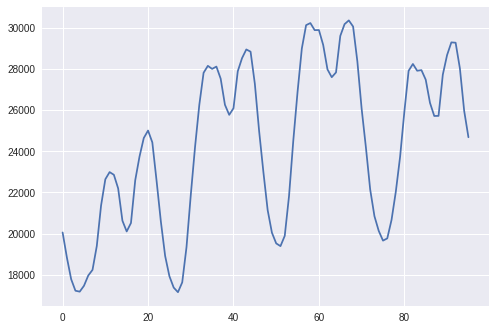

In [18]:
data_array = df['value'].to_numpy()
train_split = int(.7 * int(data_array.shape[0]))
val_data_plot = data_array[train_split:]
plt.plot(val_data_plot[-96:])


In [19]:
y_val

array([[23573., 27320., 29847., 30525., 31152., 31389.],
       [27320., 29847., 30525., 31152., 31389., 31555.],
       [29847., 30525., 31152., 31389., 31555., 31677.],
       ...,
       [25716., 27715., 28666., 29282., 29266., 28022.],
       [27715., 28666., 29282., 29266., 28022., 25964.],
       [28666., 29282., 29266., 28022., 25964., 24680.]])

In [20]:
y_hat

array([[23212.117, 25945.465, 28041.676, 29132.498, 29989.922, 30328.25 ],
       [26277.502, 28086.117, 29349.984, 30073.361, 30561.217, 30809.89 ],
       [29400.484, 30376.55 , 30981.691, 31198.648, 31574.787, 31616.453],
       ...,
       [26577.219, 27778.03 , 28873.818, 29795.846, 29808.043, 28022.041],
       [27178.264, 28362.105, 28843.81 , 28717.373, 27467.533, 25182.684],
       [28631.164, 29162.686, 28808.943, 27273.023, 25362.12 , 23707.62 ]],
      dtype=float32)

In [21]:
#val_data_plot.shape[0]-y_val.shape[0]
val_data_plot = val_data_plot[96:]

In [22]:
val_data_plot

array([23573, 27320, 29847, ..., 28022, 25964, 24680])

(144,)
(144, 6)


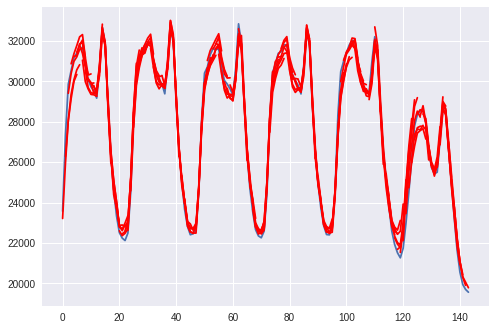

In [27]:
# plot the entire dataset in blue

test_size = 144
real_data = val_data_plot[:test_size]
print(real_data.shape)
forecastings = y_hat[:test_size]
print(forecastings.shape)
plt.plot(real_data)
# plot the forecasts in red
for i in range(len(forecastings)):
    xaxis = np.arange(i, forecastings.shape[1]+i)
    if xaxis[-1] > real_data.shape[0]-1:
        continue
    plt.plot(xaxis, forecastings[i], color='red')
# show the plot
plt.show()

In [24]:
real_data

array([23573, 27320, 29847, 30525, 31152, 31389, 31555, 31677, 30842,
       30088, 29718, 29530, 29158, 30599, 32656, 31816, 29002, 26348,
       24640, 23335, 22510, 22242, 22121, 22488, 24522, 28178, 30532,
       30951, 31368, 31675, 31922, 31899, 30989, 30375, 30052, 29870,
       29373, 30794, 32774, 31876, 29102, 26608, 25006, 23652, 22822,
       22407, 22457, 22637, 24536, 28148, 30396, 30693, 31304, 31611,
       31554, 31598, 30697, 30035, 29854, 29619, 29312, 30648, 32832,
       31856, 28867, 26404, 24684, 23533, 22658, 22349, 22257, 22585,
       24436, 28086, 30428, 30853, 31376, 31455, 31794, 31791, 30931,
       30306, 30021, 29796, 29367, 30822, 32584, 31742, 28825, 26559,
       24945, 23727, 22854, 22418, 22402, 22755, 24550, 28300, 30464,
       30980, 31402, 31782, 32010, 31984, 31031, 30190, 29746, 29520,
       29446, 30979, 32196, 31306, 28753, 26555, 25187, 23772, 22581,
       21928, 21515, 21266, 21741, 22992, 24503, 26113, 27774, 28339,
       28527, 28610,

In [25]:
forecastings

array([[23212.117, 25945.465, 28041.676, 29132.498, 29989.922, 30328.25 ],
       [26277.502, 28086.117, 29349.984, 30073.361, 30561.217, 30809.89 ],
       [29400.484, 30376.55 , 30981.691, 31198.648, 31574.787, 31616.453],
       ...,
       [27741.371, 27844.195, 27507.217, 26406.424, 25654.86 , 25659.986],
       [27286.21 , 26843.74 , 26262.05 , 25154.06 , 25195.504, 26641.361],
       [26985.578, 25947.916, 25098.5  , 25421.86 , 26543.797, 28172.568]],
      dtype=float32)